# Reinforcement Learning Neural Cellular Automata

## Introduction

In Growing Neural Cellular Automata, NCA learns using backpropagation through time.

- Backpropagation through time is expensive in time and space.
- The horizon needs to be large because the loss between the starting seed and the state after a short horizon is not meaningful. Indeed, the horizon should be at least half of the time required for the developmental process to complete.
- The training procedure forces all intermediate steps to resemble the target morphology, which is a bad design. Intermediate state reached by the NCA should only be evaluated with regards to their capacity to reach the target at the end of the developmental process.
- Reinforcement learning provide the exact tools required for a more efficient training procedure of NCA.
- We can benefit from years of research and development in reinforcement learning and transfer those tools to NCA training. 

## Import

In [2]:
from functools import partial

import jax
import jax.numpy as jnp
import mediapy
import optax
from cax.core.ca import CA
from cax.core.perceive.depthwise_conv_perceive import DepthwiseConvPerceive
from cax.core.perceive.kernels import grad_kernel, identity_kernel
from cax.core.state import state_from_rgba_to_rgb, state_to_rgba
from cax.core.update.nca_update import NCAUpdate
from cax.nn.buffer import Buffer
from cax.nn.vae import VAE, vae_loss
from cax.types import Input, State
from cax.utils.image import get_emoji
from flax import nnx
from tqdm.auto import tqdm

## Configuration

In [3]:
seed = 0

channel_size = 16
num_kernels = 3
hidden_size = 128
cell_dropout_rate = 0.5
latent_size = 8

buffer_size = 10_024
horizon = 16
discount = 0.997
lambda_ = 0.95

batch_size = 8
num_steps = 16
learning_rate = 1e-3

emoji = "🦎"
target_size = 40
target_padding = 16

key = jax.random.PRNGKey(seed)
rngs = nnx.Rngs(seed)

2024-09-18 08:08:03.661053: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.5 which is older than the PTX compiler version (12.6.68). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## Dataset

""

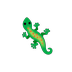

In [4]:
target = get_emoji(emoji, size=target_size, padding=target_padding)

mediapy.show_image(target)

## Init state

In [5]:
def init_state():
	state_shape = target.shape[:2] + (channel_size,)

	state = jnp.zeros(state_shape)
	mid = (size // 2 for size in state_shape[:-1])
	return state.at[*mid, -1].set(1.0)

## Model

In [6]:
class Critic(nnx.Module):
	"""Critic module for Reinforcement Learning NCA."""

	linear_1: nnx.Linear
	linear_2: nnx.Linear

	def __init__(self, latent_size: int, hidden_size: int, rngs: nnx.Rngs):
		"""Initialize the Critic module.

		Args:
			latent_size: Size of the latent space.
			rngs: Random number generators.

		"""
		super().__init__()

		self.linear_1 = nnx.Linear(in_features=latent_size, out_features=hidden_size, rngs=rngs)
		self.linear_2 = nnx.Linear(in_features=hidden_size, out_features=1, rngs=rngs)

	def __call__(self, x):
		"""Forward pass of the critic.

		Args:
			x: Input tensor.

		Returns:
			Tuple of mean and log variance of the return distribution.

		"""
		x = jax.nn.relu(self.linear_1(x))
		x = jnp.squeeze(self.linear_2(x))
		return x

In [7]:
from collections.abc import Sequence


class Critic(nnx.Module):
	"""Critic module for Reinforcement Learning NCA."""

	convs: Sequence[nnx.Conv]
	linear_1: nnx.Linear
	linear_2: nnx.Linear

	def __init__(self, spatial_dims: Sequence[int], features: Sequence[int], latent_size: int, hidden_size: int, rngs: nnx.Rngs):
		"""Initialize the Critic module.

		Args:
			latent_size: Size of the latent space.
			rngs: Random number generators.

		"""
		super().__init__()
		self.features = features
		self.latent_size = latent_size

		self.convs = []
		for in_features, out_features in zip(self.features[:-1], self.features[1:]):
			self.convs.append(
				nnx.Conv(
					in_features=in_features,
					out_features=out_features,
					kernel_size=(3, 3),
					strides=(2, 2),
					padding="SAME",
					rngs=rngs,
				)
			)

		flattened_size = spatial_dims[0] * spatial_dims[1] * self.features[-1]
		for _ in range(len(self.features) - 1):
			flattened_size //= 4

		self.linear_1 = nnx.Linear(in_features=flattened_size, out_features=hidden_size, rngs=rngs)
		self.linear_2 = nnx.Linear(in_features=hidden_size, out_features=1, rngs=rngs)

	def __call__(self, x):
		"""Forward pass of the critic.

		Args:
			x: Input tensor.

		Returns:
			Tuple of mean and log variance of the return distribution.

		"""
		for conv in self.convs:
			x = jax.nn.relu(conv(x))
		x = x.reshape(*x.shape[:-3], -1)
		x = jax.nn.relu(self.linear_1(x))
		x = jnp.squeeze(self.linear_2(x))
		return x

In [8]:
perceive = DepthwiseConvPerceive(channel_size, rngs)
update = NCAUpdate(channel_size, num_kernels * channel_size, (hidden_size,), rngs, cell_dropout_rate=cell_dropout_rate)
vae = VAE((72, 72), (4, 32, 32), latent_size, rngs)
critic = Critic((72, 72), (4, 16, 16), latent_size, 128, rngs)

class RLCA(CA):
	vae: VAE
	critic: Critic

	def __init__(self, perceive, update, vae, critic):
		super().__init__(perceive, update)
		self.vae = vae
		self.critic = critic

	# @nnx.jit
	# def reward_fn(self, state, next_state):
	# 	latent_state, _, _ = self.vae.encode(state_to_rgba(state))
	# 	latent_next_state, _, _ = self.vae.encode(state_to_rgba(next_state))
	# 	latent_target, _, _ = self.vae.encode(target)
	# 	return jnp.mean(jnp.square(latent_state - latent_target)) - jnp.mean(jnp.square(latent_next_state - latent_target))

	@nnx.jit
	def reward_fn(self, state, next_state):
		# latent_state, _, _ = self.vae.encode(state_to_rgba(state))
		# latent_next_state, _, _ = self.vae.encode(state_to_rgba(next_state))
		# latent_target, _, _ = self.vae.encode(target)
		return jnp.mean(jnp.square(state_to_rgba(state) - target)) - jnp.mean(jnp.square(state_to_rgba(next_state) - target))

	@partial(nnx.jit, static_argnames=("num_steps", "all_steps", "input_in_axis"))
	def __call__(
		self,
		state: State,
		input: Input = None,
		*,
		num_steps: int = 1,
		all_steps: bool = False,
		input_in_axis: int | None = None,
	) -> State:
		"""Run the CA for multiple steps.

		Args:
			state: Initial state.
			input: Optional input.
			num_steps: Number of steps to run.
			all_steps: Whether to return all intermediate states.
			input_in_axis: Axis for input if provided for each step.

		Returns:
			Final state or all intermediate states if all_steps is True.

		"""

		def step(carry, input):
			ca, state = carry
			next_state = ca.step(state, input)
			reward = ca.reward_fn(state, next_state)
			return (ca, next_state), (next_state, reward) if all_steps else None

		(_, state), (states, rewards) = nnx.scan(
			step,
			in_axes=(nnx.Carry, input_in_axis),
			length=num_steps,
		)((self, state), input)

		return (states, rewards) if all_steps else state

In [9]:
kernel = jnp.concatenate([identity_kernel(ndim=2), grad_kernel(ndim=2)], axis=-1)
kernel = jnp.expand_dims(jnp.concatenate([kernel] * channel_size, axis=-1), axis=-2)
perceive.depthwise_conv.kernel = nnx.Param(kernel)

In [10]:
ca = RLCA(perceive, update, vae, critic)

In [11]:
params = nnx.state(ca, nnx.Param)
print("Number of params:", jax.tree.reduce(lambda x, y: x + y.size, params, 0))

Number of params: 108461333


## Train

### Buffer

In [12]:
state = init_state()
buffer = Buffer.create(size=buffer_size, datum={"state": state})

### Optimizer

In [13]:
lr_sched = optax.linear_schedule(init_value=learning_rate, end_value=0.1 * learning_rate, transition_steps=50_000)

optimizer = optax.chain(
	optax.clip_by_global_norm(1.0),
	optax.adam(learning_rate=lr_sched),
)

update_params = nnx.All(nnx.Param, nnx.PathContains("update"))
optimizer_ca = nnx.Optimizer(ca, optimizer, wrt=update_params)

vae_params = nnx.All(nnx.Param, nnx.PathContains("vae"))
optimizer_vae = nnx.Optimizer(ca, optimizer, wrt=vae_params)

critic_params = nnx.All(nnx.Param, nnx.PathContains("critic"))
optimizer_critic = nnx.Optimizer(ca, optimizer, wrt=critic_params)

### Loss

In [13]:
@nnx.jit
def loss_fn(ca, state, key):
	state_axes = nnx.StateAxes({nnx.RngState: 0, ...: None})
	states, rewards = nnx.split_rngs(splits=batch_size)(
		nnx.vmap(
			lambda ca, state: ca(state, num_steps=horizon, all_steps=True),
			in_axes=(state_axes, 0),
		)
	)(ca, state)

	# Compute values
	# latent_states = ca.vae.encode(state_to_rgba(states))
	values = ca.critic(state_to_rgba(states))

	# Compute target
	bootstrap = values[:, -1]

	# n-step bootstrap
	discount_powers = jnp.power(discount, jnp.arange(horizon))
	target = jnp.sum(rewards * discount_powers, axis=-1) + jnp.power(discount, horizon) * bootstrap

	# Compute critic loss
	loss_critic = jnp.sum(jnp.square(jax.lax.stop_gradient(target) - values[:, 0]))

	# Compute ca loss
	loss_ca = -jnp.sum(values[:, -1])

	return loss_ca, loss_critic


@nnx.jit
def loss_ca_fn(ca, state, key):
	loss, _ = loss_fn(ca, state, key)
	return loss

def loss_vae_fn(ca, image):
	image_recon, mean, logvar = ca.vae(image)
	return vae_loss(image_recon, image, mean, logvar)

@nnx.jit
def loss_critic_fn(ca, state, key):
	_, loss = loss_fn(ca, state, key)
	return loss

In [13]:
@nnx.jit
def loss_fn(ca, state, key):
	state_axes = nnx.StateAxes({nnx.RngState: 0, ...: None})
	states, rewards = nnx.split_rngs(splits=batch_size)(
		nnx.vmap(
			lambda ca, state: ca(state, num_steps=horizon, all_steps=True),
			in_axes=(state_axes, 0),
		)
	)(ca, state)

	# Compute values
	# latent_states = ca.vae.encode(state_to_rgba(states))
	values = ca.critic(state_to_rgba(states))

	# Compute lambda-return
	init = ((1 - discount * (1 - lambda_)) * values[..., -1] - rewards[..., -1])/(discount * lambda_)
	xs = rewards + discount * (1 - lambda_) * values

	def scan_fn(carry, x):
		lambda_return = x + discount * lambda_ * carry
		return lambda_return, lambda_return

	_, lambda_returns = nnx.vmap(lambda init, xs: jax.lax.scan(
		scan_fn,
		init,
		xs,
		reverse=True,
	))(init, xs)

	# Compute critic loss
	loss_critic = jnp.sum(jnp.square(jax.lax.stop_gradient(lambda_returns) - values))

	# Compute ca loss
	loss_ca = -jnp.sum(values)

	return loss_ca, loss_critic

@nnx.jit
def loss_ca_fn(ca, state, key):
	loss, _ = loss_fn(ca, state, key)
	return loss

@nnx.jit
def loss_vae_fn(ca, image):
	image_recon, mean, logvar = ca.vae(image)
	return vae_loss(image_recon, image, mean, logvar)

@nnx.jit
def loss_critic_fn(ca, state, key):
	_, loss = loss_fn(ca, state, key)
	return loss

### Train step

In [14]:
@nnx.jit
def act(ca, buffer):
	state = jax.vmap(lambda _: init_state())(jnp.zeros(batch_size))
	seed = init_state()
	seed = seed.at[..., -4:].set(target)
	state = jnp.stack([seed] * batch_size)

	state_axes = nnx.StateAxes({nnx.RngState: 0, ...: None})
	state, _ = nnx.split_rngs(splits=batch_size)(
		nnx.vmap(
			lambda ca, state: ca(state, num_steps=num_steps, all_steps=True),
			in_axes=(state_axes, 0),
		)
	)(ca, state)

	state = jnp.reshape(state, (batch_size * num_steps, *state.shape[2:]))
	buffer = buffer.add({"state": state})

	return ca, buffer

@nnx.jit
def train_step(ca, optimizer_ca, optimizer_vae, optimizer_critic, buffer, key):
	sample_key, loss_key = jax.random.split(key)

	# Sample from buffer
	batch = buffer.sample(sample_key, batch_size=batch_size)
	current_state = batch["state"]

	# Sort by descending loss
	sort_index = jnp.argsort(jax.vmap(lambda state: jnp.mean(jnp.square(state_to_rgba(state) - target)))(current_state), descending=True)
	current_state = current_state[sort_index]

	# Sample a new target to replace the worst
	num_seeds = 1
	new_state = jax.vmap(lambda _: init_state())(jnp.zeros(num_seeds))
	current_state = current_state.at[:num_seeds].set(new_state)

	# Train vae
	loss_vae, grad = nnx.value_and_grad(loss_vae_fn, argnums=nnx.DiffState(0, vae_params))(ca, state_to_rgba(current_state))
	optimizer_vae.update(grad)

	# Train critic
	loss_critic, grad = nnx.value_and_grad(loss_critic_fn, argnums=nnx.DiffState(0, critic_params))(ca, current_state, loss_key)
	optimizer_critic.update(grad)

	# Train CA
	loss_ca, grad = nnx.value_and_grad(loss_ca_fn, argnums=nnx.DiffState(0, update_params))(ca, current_state, loss_key)
	optimizer_ca.update(grad)

	return loss_ca, loss_vae, loss_critic

### Main loop

In [15]:
num_train_steps = 8_192
print_interval = 1

pbar = tqdm(range(num_train_steps), desc="Training", unit="train_step")
losses_ca = []
losses_vae = []
losses_critic = []

for i in pbar:
	key, subkey = jax.random.split(key)

	ca, buffer = act(ca, buffer)
	loss_ca, loss_vae, loss_critic = train_step(ca, optimizer_ca, optimizer_vae, optimizer_critic, buffer, subkey)

	losses_ca.append(loss_ca)
	losses_vae.append(loss_vae)
	losses_critic.append(loss_critic)

	if i % print_interval == 0 or i == num_train_steps - 1:
		avg_loss_ca = sum(losses_ca[-print_interval:]) / len(losses_ca[-print_interval:])
		avg_loss_vae = sum(losses_vae[-print_interval:]) / len(losses_vae[-print_interval:])
		avg_loss_critic = sum(losses_critic[-print_interval:]) / len(losses_critic[-print_interval:])
		pbar.set_postfix({"Average Loss CA": f"{avg_loss_ca:.6f}", "Average Loss VAE": f"{avg_loss_vae:.6f}", "Average Loss Critic": f"{avg_loss_critic:.6f}"})

Training:   0%|          | 0/8192 [00:00<?, ?train_step/s]

KeyboardInterrupt: 

## Visualize

In [2]:
mediapy.show_images(state_from_rgba_to_rgb(buffer.data["state"][10:20]), width=128, height=128)

NameError: name 'mediapy' is not defined

In [34]:
state = jax.vmap(lambda _: init_state())(jnp.zeros(8))

In [16]:
state = init_state()
state = state.at[..., -4:].set(target)
state = jnp.stack([state] * 8)

In [17]:
state_axes = nnx.StateAxes({nnx.RngState: 0, ...: None})
state, _ = nnx.split_rngs(splits=8)(
	nnx.vmap(
		lambda ca, state: ca(state, num_steps=num_steps, all_steps=True),
		in_axes=(state_axes, 0),
	)
)(ca, state)

,,,,,,,

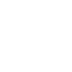
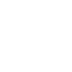
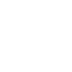
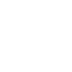
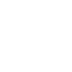
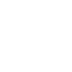
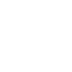
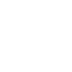

,,,,,,,

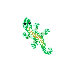
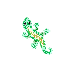
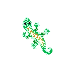
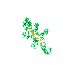
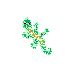
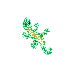
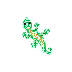
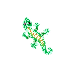

In [18]:
mediapy.show_images(state_to_rgba(state[:, -1]), width=128, height=128)
mediapy.show_videos(state_from_rgba_to_rgb(state), width=128, height=128, codec="gif")

""

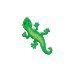

""

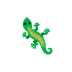

In [ ]:
state = init_state()
state = state.at[..., -4:].set(target)

state, _ = ca(state, num_steps=2 * num_steps, all_steps=True)

mediapy.show_image(state_to_rgba(state[-1]))
mediapy.show_video(state_from_rgba_to_rgb(state), width=256, height=256, codec="gif")